In [1]:
#COMET ML API KEY YarDlAXZLHepLKBFlSPyWbDPt
import comet_ml
comet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")
from comet_ml import Experiment
experiment = Experiment(
    api_key="YarDlAXZLHepLKBFlSPyWbDPt",
    project_name="atp-simplified-classification-with-interpolation",
    workspace="mattbeze",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)

Saving config to "C:\Users\mattbeze\.comet.config"... done!


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mattbeze/atp-simplified-classification-with-interpolation/c54c48ff9595453e90522c1ef461d605



In [2]:
import numpy as np
import seaborn as sn
from imblearn.over_sampling import SMOTE 
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from pandas import DataFrame
import xlsxwriter
import time

#Extra features that are available: Sex, Gestational Age 
seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
#22 1s Atypicals defined as having an attention problem t-score >= 65 in BASC2 6year
#115 0s

Using TensorFlow backend.


In [3]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP Middle'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

#Set to the same seed as my gridSearchCV until I can run more gridSearchCVs with random seeds and average them. This is after I try the different class weight gridSearches.

(129, 298)
(129, 1)


In [4]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[8])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['ATP Middle'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[1])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)

(33, 298)
(33, 1)


In [5]:
data_features = data_features.to_numpy()
labels = labels.to_numpy()

interpolated_data_features = interpolated_data_features.to_numpy()
interpolated_labels = interpolated_labels.to_numpy()
interpolated_labels = interpolated_labels.flatten()

skf = StratifiedKFold(n_splits=8, random_state=seed_value)
skf.get_n_splits(data_features, labels)
print(skf)

training_folds_X = []
testing_folds_X = []
training_folds_Y = []
testing_folds_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features[train_index], data_features[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    X_train_complete = np.concatenate([X_train_smoted,interpolated_data_features])
    Y_train_complete = np.concatenate([Y_train_smoted,interpolated_labels])
    training_folds_X.append(X_train_complete)
    testing_folds_X.append(X_test)
    training_folds_Y.append(Y_train_complete)
    testing_folds_Y.append(Y_test)

StratifiedKFold(n_splits=8, random_state=7, shuffle=False)


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [6]:
def create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7):
    predictions = []
    true = []
    
    for i in range(0,p0.size):
        if p0[i] == 0:
            predictions.append(0)
        if p0[i] == 1:
            predictions.append(1)
        if t0[i] == 0:
            true.append(0)
        if t0[i] == 1:
            true.append(1)
    for i in range(0,p1.size):
        if p1[i] == 0:
            predictions.append(0)
        if p1[i] == 1:
            predictions.append(1)
        if t1[i] == 0:
            true.append(0)
        if t1[i] == 1:
            true.append(1)
    for i in range(0,p2.size):
        if p2[i] == 0:
            predictions.append(0)
        if p2[i] == 1:
            predictions.append(1)
        if t2[i] == 0:
            true.append(0)
        if t2[i] == 1:
            true.append(1)
    for i in range(0,p3.size):
        if p3[i] == 0:
            predictions.append(0)
        if p3[i] == 1:
            predictions.append(1)
        if t3[i] == 0:
            true.append(0)
        if t3[i] == 1:
            true.append(1)
    for i in range(0,p4.size):
        if p4[i] == 0:
            predictions.append(0)
        if p4[i] == 1:
            predictions.append(1)
        if t4[i] == 0:
            true.append(0)
        if t4[i] == 1:
            true.append(1)
    for i in range(0,p5.size):
        if p5[i] == 0:
            predictions.append(0)
        if p5[i] == 1:
            predictions.append(1)
        if t5[i] == 0:
            true.append(0)
        if t5[i] == 1:
            true.append(1)
    for i in range(0,p6.size):
        if p6[i] == 0:
            predictions.append(0)
        if p6[i] == 1:
            predictions.append(1)
        if t6[i] == 0:
            true.append(0)
        if t6[i] == 1:
            true.append(1)
    for i in range(0,p7.size):
        if p7[i] == 0:
            predictions.append(0)
        if p7[i] == 1:
            predictions.append(1)
        if t7[i] == 0:
            true.append(0)
        if t7[i] == 1:
            true.append(1)
    
    
    prec_score = precision_score(true, predictions, average=None)
    print('Positive Predictive Value tp/(tp+fp): ',prec_score[1])
    
    rec_score = recall_score(true, predictions, average=None)
    print('Recall Value tp/(tp+fn): ',rec_score[1])
    
    cf_matrix = confusion_matrix(true, predictions)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    

In [7]:
#Best: 0.497768 using {'batch_size': 35, 'dropout': 0.3, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 20}
def run_model(n):
    predictor = keras.models.load_model('ASD Pre_Trained Model for ATP Simplified') #Model with ASD Pre-training

    class_weights={0:1, 1:4} 
    
    p = predictor.fit(training_folds_X[n], training_folds_Y[n],
    epochs=100,
    batch_size=35,
    shuffle=False,
    validation_data=(testing_folds_X[n], testing_folds_Y[n]), class_weight=class_weights)

    #Plotting loss
    plt.plot(p.history['loss'])
    plt.plot(p.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.axis([0, 100, 0.0, 1.10])
    plt.show()

    #Plotting Accuracy
    plt.plot(p.history['acc'])
    plt.plot(p.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.axis([0, 100, 0.0, 1.05])
    plt.show()
    
    
    predictions = predictor.predict(testing_folds_X[n])
    predicted_classes = (predictions > 0.5).astype(int)

    #Heatmap for the confusion matrix
    cf_matrix = confusion_matrix(testing_folds_Y[n], predicted_classes)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    average_precision = average_precision_score(predicted_classes, testing_folds_Y[n])

    
    prec_score = precision_score(testing_folds_Y[n], predicted_classes, average=None)
    print('PPV: ',prec_score[1])
    
    rec_score = recall_score(testing_folds_Y[n], predicted_classes, average=None)
    print('Recall: ',rec_score[1])

    
    return predicted_classes, testing_folds_Y[n]
    


COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train on 219 samples, validate on 17 samples
Epoch 1/100
 35/219 [===>..........................] - ETA: 3:26 - loss: 3.4126 - acc: 0.8000

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


219/219 [==============================] - 40s 183ms/step - loss: 2.2284 - acc: 0.6210 - val_loss: 4.8593 - val_acc: 0.1765
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 2.3916 - acc: 0.4566 - val_loss: 0.9870 - val_acc: 0.1765
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 1.8379 - acc: 0.4703 - val_loss: 1.5213 - val_acc: 0.1765
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 1.3101 - acc: 0.4475 - val_loss: 1.6117 - val_acc: 0.1765
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 1.3983 - acc: 0.4475 - val_loss: 1.0675 - val_acc: 0.1765
Epoch 6/100
219/219 [==============================] - 0s 981us/step - loss: 1.2821 - acc: 0.4795 - val_loss: 1.0513 - val_acc: 0.1765
Epoch 7/100
219/219 [==============================] - 0s 908us/step - loss: 1.1749 - acc: 0.4703 - val_loss: 1.2007 - val_acc: 0.1765
Epoch 8/100
219/219 [==============================] - 0s 921us/step - los

Epoch 62/100
219/219 [==============================] - 0s 750us/step - loss: 0.1666 - acc: 0.9452 - val_loss: 0.7299 - val_acc: 0.7647
Epoch 63/100
219/219 [==============================] - 0s 696us/step - loss: 0.1475 - acc: 0.9635 - val_loss: 0.7462 - val_acc: 0.7647
Epoch 64/100
219/219 [==============================] - 0s 987us/step - loss: 0.1783 - acc: 0.9406 - val_loss: 0.6510 - val_acc: 0.7647
Epoch 65/100
219/219 [==============================] - 0s 2ms/step - loss: 0.1745 - acc: 0.9635 - val_loss: 0.7760 - val_acc: 0.8235
Epoch 66/100
219/219 [==============================] - 0s 2ms/step - loss: 0.1655 - acc: 0.9589 - val_loss: 0.6723 - val_acc: 0.7647
Epoch 67/100
219/219 [==============================] - 0s 1ms/step - loss: 0.1483 - acc: 0.9589 - val_loss: 0.6478 - val_acc: 0.7647
Epoch 68/100
219/219 [==============================] - 0s 919us/step - loss: 0.1911 - acc: 0.9543 - val_loss: 0.7154 - val_acc: 0.7647
Epoch 69/100
219/219 [==============================] 

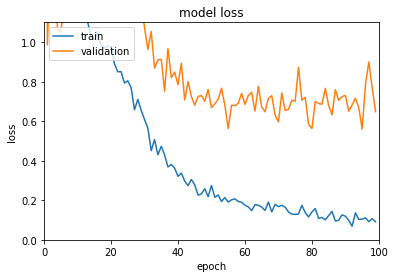

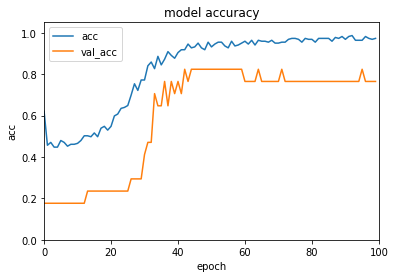

[[11  3]
 [ 1  2]]
PPV:  0.4
Recall:  0.6666666666666666


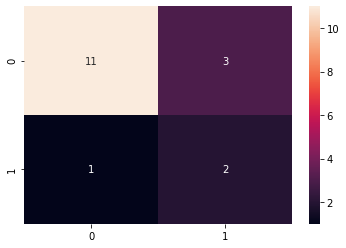

In [8]:
p0, t0 = run_model(0)

In [ ]:
p1, t1 = run_model(1)

COMET WARNING: Set model graph by 'keras' ignored; already called. Future attempts are silently ignored.


Train on 219 samples, validate on 16 samples
Epoch 1/100
219/219 [==============================] - 5s 22ms/step - loss: 1.9207 - acc: 0.6575 - val_loss: 5.4682 - val_acc: 0.1250
Epoch 2/100
219/219 [==============================] - 0s 1ms/step - loss: 2.3211 - acc: 0.4521 - val_loss: 1.2066 - val_acc: 0.1250
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 1.3120 - acc: 0.4703 - val_loss: 1.5005 - val_acc: 0.1250
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 1.1787 - acc: 0.4658 - val_loss: 1.5183 - val_acc: 0.1250
Epoch 5/100
219/219 [==============================] - 0s 786us/step - loss: 1.1975 - acc: 0.4749 - val_loss: 1.3369 - val_acc: 0.1250
Epoch 6/100
219/219 [==============================] - 0s 1ms/step - loss: 1.1627 - acc: 0.4886 - val_loss: 1.3026 - val_acc: 0.1250
Epoch 7/100
219/219 [==============================] - 0s 1ms/step - loss: 1.1055 - acc: 0.5023 - val_loss: 1.3796 - val_acc: 0.1250
Epoch 8/100
219/219 [

Epoch 30/100
219/219 [==============================] - 0s 1ms/step - loss: 0.3175 - acc: 0.9452 - val_loss: 0.7940 - val_acc: 0.6875
Epoch 31/100
219/219 [==============================] - 0s 1ms/step - loss: 0.2821 - acc: 0.9178 - val_loss: 0.7669 - val_acc: 0.6875
Epoch 32/100
219/219 [==============================] - 0s 1ms/step - loss: 0.2667 - acc: 0.9361 - val_loss: 0.8530 - val_acc: 0.6250
Epoch 33/100
219/219 [==============================] - 0s 1ms/step - loss: 0.2682 - acc: 0.9269 - val_loss: 0.6819 - val_acc: 0.7500
Epoch 34/100
219/219 [==============================] - 0s 1ms/step - loss: 0.2375 - acc: 0.9361 - val_loss: 0.7264 - val_acc: 0.7500
Epoch 35/100
219/219 [==============================] - 0s 950us/step - loss: 0.2140 - acc: 0.9589 - val_loss: 0.7943 - val_acc: 0.7500
Epoch 36/100
219/219 [==============================] - 0s 868us/step - loss: 0.2300 - acc: 0.9406 - val_loss: 0.7846 - val_acc: 0.7500
Epoch 37/100
219/219 [==============================] - 0s

219/219 [==============================] - 0s 773us/step - loss: 0.0547 - acc: 0.9863 - val_loss: 1.1946 - val_acc: 0.6875
Epoch 92/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0792 - acc: 0.9817 - val_loss: 1.0482 - val_acc: 0.8125
Epoch 93/100
219/219 [==============================] - 0s 887us/step - loss: 0.0496 - acc: 0.9954 - val_loss: 1.0725 - val_acc: 0.7500
Epoch 94/100
219/219 [==============================] - 0s 992us/step - loss: 0.0769 - acc: 0.9863 - val_loss: 1.1528 - val_acc: 0.6875
Epoch 95/100
219/219 [==============================] - 0s 842us/step - loss: 0.0733 - acc: 0.9772 - val_loss: 1.1388 - val_acc: 0.6875
Epoch 96/100
219/219 [==============================] - 0s 803us/step - loss: 0.0452 - acc: 0.9817 - val_loss: 1.0757 - val_acc: 0.8125
Epoch 97/100
219/219 [==============================] - 0s 881us/step - loss: 0.0607 - acc: 0.9863 - val_loss: 1.0723 - val_acc: 0.8125
Epoch 98/100
219/219 [==============================] - 0s 759u

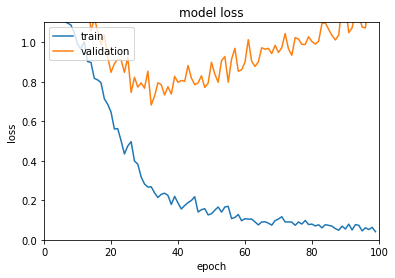

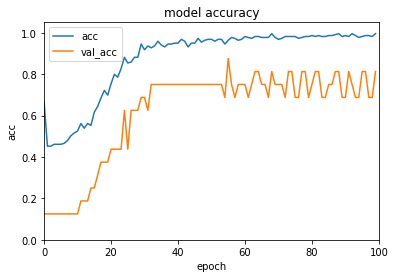

[[13  1]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


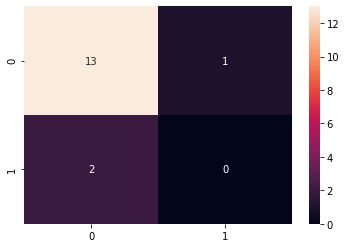

In [10]:
p2, t2 = run_model(2)

Train on 221 samples, validate on 16 samples
Epoch 1/100
221/221 [==============================] - 4s 20ms/step - loss: 2.1464 - acc: 0.6697 - val_loss: 4.6681 - val_acc: 0.1875
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 2.3732 - acc: 0.4661 - val_loss: 0.9448 - val_acc: 0.1875
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.4032 - acc: 0.4525 - val_loss: 1.5230 - val_acc: 0.1875
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2678 - acc: 0.4570 - val_loss: 1.4397 - val_acc: 0.1875
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2513 - acc: 0.4796 - val_loss: 1.1079 - val_acc: 0.1875
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 1.1842 - acc: 0.4977 - val_loss: 1.0744 - val_acc: 0.1875
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 1.1319 - acc: 0.5023 - val_loss: 1.2150 - val_acc: 0.1875
Epoch 8/100
221/221 [==

221/221 [==============================] - ETA: 0s - loss: 0.0462 - acc: 1.000 - 0s 1ms/step - loss: 0.0848 - acc: 0.9955 - val_loss: 0.6509 - val_acc: 0.8750
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0997 - acc: 0.9864 - val_loss: 0.6797 - val_acc: 0.8750
Epoch 63/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1077 - acc: 0.9729 - val_loss: 0.6998 - val_acc: 0.8750
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0852 - acc: 0.9819 - val_loss: 0.6694 - val_acc: 0.8750
Epoch 65/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0973 - acc: 0.9819 - val_loss: 0.6410 - val_acc: 0.8750
Epoch 66/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0993 - acc: 0.9774 - val_loss: 0.6486 - val_acc: 0.8750
Epoch 67/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1081 - acc: 0.9774 - val_loss: 0.6890 - val_acc: 0.8750
Epoch 68/100
221/221 [===============

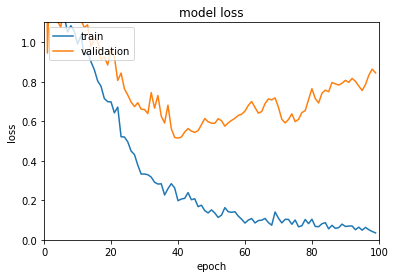

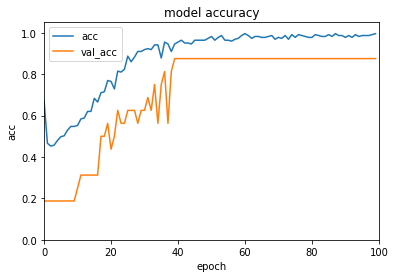

[[13  0]
 [ 2  1]]
PPV:  1.0
Recall:  0.3333333333333333


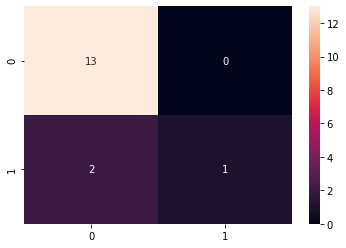

In [11]:
p3, t3 = run_model(3)

Train on 221 samples, validate on 16 samples
Epoch 1/100
221/221 [==============================] - 6s 25ms/step - loss: 2.3840 - acc: 0.6697 - val_loss: 5.0117 - val_acc: 0.1875
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 2.4951 - acc: 0.4887 - val_loss: 1.0282 - val_acc: 0.1875
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.6078 - acc: 0.4751 - val_loss: 1.1875 - val_acc: 0.1875
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 1.1653 - acc: 0.4615 - val_loss: 1.5874 - val_acc: 0.1875
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2170 - acc: 0.4525 - val_loss: 1.3224 - val_acc: 0.1875
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 1.2286 - acc: 0.4525 - val_loss: 1.0704 - val_acc: 0.1875
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2228 - acc: 0.4480 - val_loss: 1.1844 - val_acc: 0.1875
Epoch 8/100
221/221 [==

C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/221 [==============================] - 1s 3ms/step - loss: 0.4402 - acc: 0.8462 - val_loss: 0.7779 - val_acc: 0.6875
Epoch 34/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4509 - acc: 0.8869 - val_loss: 0.7184 - val_acc: 0.7500
Epoch 35/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3587 - acc: 0.8552 - val_loss: 0.6998 - val_acc: 0.7500
Epoch 36/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3864 - acc: 0.9095 - val_loss: 0.6653 - val_acc: 0.7500
Epoch 37/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3257 - acc: 0.9005 - val_loss: 0.7048 - val_acc: 0.7500
Epoch 38/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3645 - acc: 0.9050 - val_loss: 0.6404 - val_acc: 0.8125
Epoch 39/100
221/221 [==============================] - 0s 2ms/step - loss: 0.3285 - acc: 0.8869 - val_loss: 0.6392 - val_acc: 0.7500
Epoch 40/100
221/221 [==============================] - 1s 3ms/step - loss:

221/221 [==============================] - 0s 1ms/step - loss: 0.0697 - acc: 0.9955 - val_loss: 0.6179 - val_acc: 0.8125
Epoch 95/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0641 - acc: 0.9910 - val_loss: 0.6478 - val_acc: 0.8750
Epoch 96/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0720 - acc: 0.9910 - val_loss: 0.5715 - val_acc: 0.8125
Epoch 97/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0869 - acc: 0.9910 - val_loss: 0.5656 - val_acc: 0.8125
Epoch 98/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0651 - acc: 0.9819 - val_loss: 0.6163 - val_acc: 0.8125
Epoch 99/100
221/221 [==============================] - 0s 856us/step - loss: 0.0814 - acc: 0.9774 - val_loss: 0.6414 - val_acc: 0.8125
Epoch 100/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0612 - acc: 0.9910 - val_loss: 0.6020 - val_acc: 0.8125


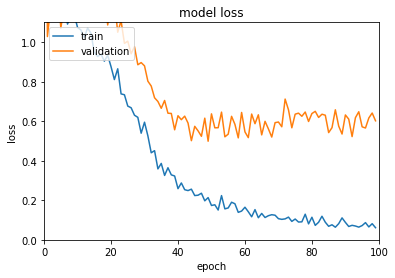

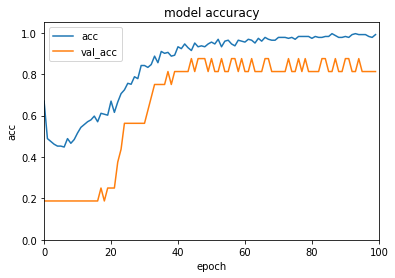

[[11  2]
 [ 1  2]]
PPV:  0.5
Recall:  0.6666666666666666


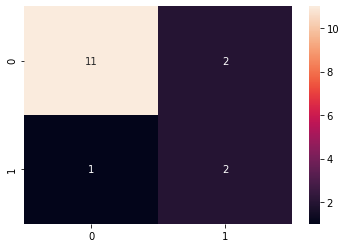

In [12]:
p4, t4 = run_model(4)

Train on 221 samples, validate on 16 samples
Epoch 1/100
221/221 [==============================] - 6s 28ms/step - loss: 2.4341 - acc: 0.6425 - val_loss: 4.1287 - val_acc: 0.2500
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 2.2504 - acc: 0.4525 - val_loss: 1.0924 - val_acc: 0.2500
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.8515 - acc: 0.4208 - val_loss: 1.1946 - val_acc: 0.1875
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 1.1773 - acc: 0.4525 - val_loss: 1.5104 - val_acc: 0.1875
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2527 - acc: 0.4389 - val_loss: 1.2930 - val_acc: 0.1875
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2505 - acc: 0.4615 - val_loss: 1.0730 - val_acc: 0.1875
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 1.2840 - acc: 0.4434 - val_loss: 1.1449 - val_acc: 0.1875
Epoch 8/100
221/221 [==

221/221 [==============================] - ETA: 0s - loss: 0.1444 - acc: 0.961 - 0s 1ms/step - loss: 0.1461 - acc: 0.9638 - val_loss: 0.5986 - val_acc: 0.7500
Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1353 - acc: 0.9819 - val_loss: 0.6053 - val_acc: 0.8125
Epoch 63/100
221/221 [==============================] - 0s 2ms/step - loss: 0.1334 - acc: 0.9729 - val_loss: 0.6085 - val_acc: 0.7500
Epoch 64/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1233 - acc: 0.9729 - val_loss: 0.6305 - val_acc: 0.7500
Epoch 65/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1250 - acc: 0.9774 - val_loss: 0.6500 - val_acc: 0.7500
Epoch 66/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1254 - acc: 0.9548 - val_loss: 0.6291 - val_acc: 0.7500
Epoch 67/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1202 - acc: 0.9774 - val_loss: 0.6456 - val_acc: 0.7500
Epoch 68/100
221/221 [===============

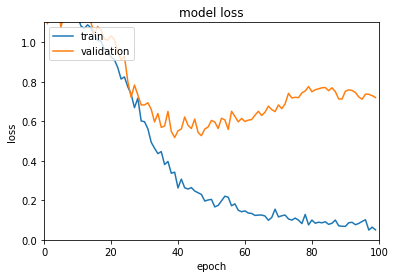

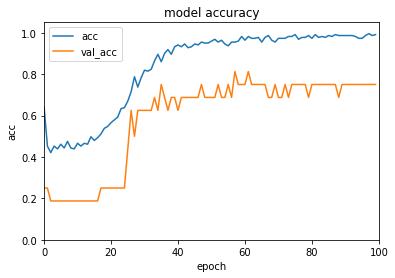

[[12  1]
 [ 3  0]]
PPV:  0.0
Recall:  0.0


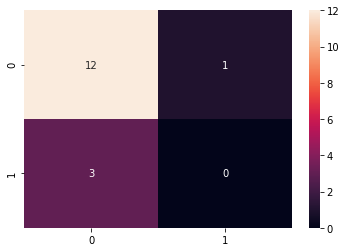

In [13]:
p5, t5 = run_model(5)

Train on 221 samples, validate on 16 samples
Epoch 1/100
221/221 [==============================] - 6s 29ms/step - loss: 2.1183 - acc: 0.6652 - val_loss: 4.3969 - val_acc: 0.1875
Epoch 2/100
221/221 [==============================] - 0s 985us/step - loss: 2.3005 - acc: 0.5068 - val_loss: 0.9014 - val_acc: 0.2500
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.4806 - acc: 0.4706 - val_loss: 1.2229 - val_acc: 0.1875
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 1.1487 - acc: 0.4615 - val_loss: 1.4285 - val_acc: 0.1875
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 1.2317 - acc: 0.4525 - val_loss: 1.1773 - val_acc: 0.1875
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 1.1891 - acc: 0.4615 - val_loss: 1.0305 - val_acc: 0.1875
Epoch 7/100
221/221 [==============================] - 0s 1ms/step - loss: 1.1638 - acc: 0.4570 - val_loss: 1.1228 - val_acc: 0.1875
Epoch 8/100
221/221 [

Epoch 62/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1232 - acc: 0.9729 - val_loss: 1.0892 - val_acc: 0.6875
Epoch 63/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1108 - acc: 0.9683 - val_loss: 1.0806 - val_acc: 0.6875
Epoch 64/100
221/221 [==============================] - 0s 925us/step - loss: 0.1304 - acc: 0.9593 - val_loss: 1.1175 - val_acc: 0.6875
Epoch 65/100
221/221 [==============================] - 0s 738us/step - loss: 0.1101 - acc: 0.9683 - val_loss: 1.0495 - val_acc: 0.6875
Epoch 66/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1088 - acc: 0.9774 - val_loss: 1.0444 - val_acc: 0.6875
Epoch 67/100
221/221 [==============================] - 0s 1ms/step - loss: 0.0927 - acc: 0.9819 - val_loss: 1.0616 - val_acc: 0.6875
Epoch 68/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1158 - acc: 0.9683 - val_loss: 1.1131 - val_acc: 0.6875
Epoch 69/100
221/221 [==============================] - 0s

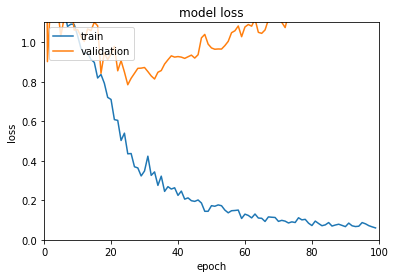

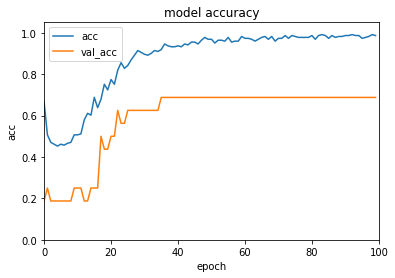

[[11  2]
 [ 3  0]]
PPV:  0.0
Recall:  0.0


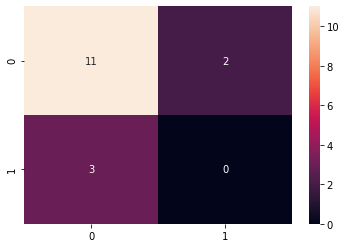

In [14]:
p6, t6 = run_model(6)

Train on 221 samples, validate on 16 samples
Epoch 1/100
221/221 [==============================] - 6s 27ms/step - loss: 2.4213 - acc: 0.6471 - val_loss: 4.7486 - val_acc: 0.1875
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 2.5047 - acc: 0.4615 - val_loss: 0.9774 - val_acc: 0.1875
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 1.7652 - acc: 0.4299 - val_loss: 1.1991 - val_acc: 0.1875
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 1.2465 - acc: 0.4480 - val_loss: 1.4663 - val_acc: 0.1875
Epoch 5/100
221/221 [==============================] - 0s 749us/step - loss: 1.2854 - acc: 0.4570 - val_loss: 1.1877 - val_acc: 0.1875
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 1.2639 - acc: 0.4615 - val_loss: 1.0531 - val_acc: 0.1875
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 1.2308 - acc: 0.4615 - val_loss: 1.1406 - val_acc: 0.1875
Epoch 8/100
221/221 [

221/221 [==============================] - 0s 1ms/step - loss: 0.2163 - acc: 0.9412 - val_loss: 0.2053 - val_acc: 0.8750
Epoch 62/100
221/221 [==============================] - 0s 910us/step - loss: 0.1620 - acc: 0.9548 - val_loss: 0.1684 - val_acc: 1.0000
Epoch 63/100
221/221 [==============================] - ETA: 0s - loss: 0.1422 - acc: 0.971 - 0s 773us/step - loss: 0.1469 - acc: 0.9729 - val_loss: 0.1609 - val_acc: 1.0000
Epoch 64/100
221/221 [==============================] - 0s 657us/step - loss: 0.1767 - acc: 0.9457 - val_loss: 0.1586 - val_acc: 1.0000
Epoch 65/100
221/221 [==============================] - 0s 575us/step - loss: 0.1487 - acc: 0.9548 - val_loss: 0.1805 - val_acc: 0.8750
Epoch 66/100
221/221 [==============================] - 0s 617us/step - loss: 0.1696 - acc: 0.9638 - val_loss: 0.1455 - val_acc: 1.0000
Epoch 67/100
221/221 [==============================] - 0s 383us/step - loss: 0.1530 - acc: 0.9683 - val_loss: 0.1744 - val_acc: 0.8750
Epoch 68/100
221/221 [===

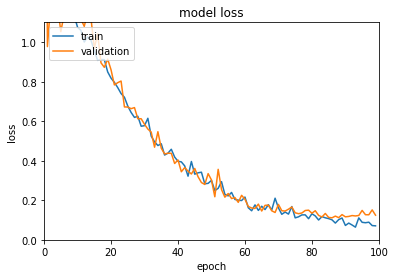

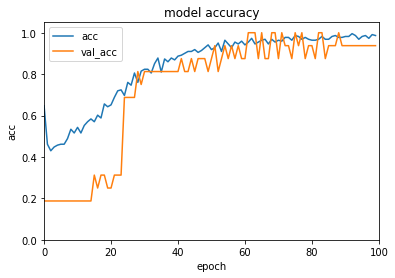

[[13  0]
 [ 1  2]]
PPV:  1.0
Recall:  0.6666666666666666


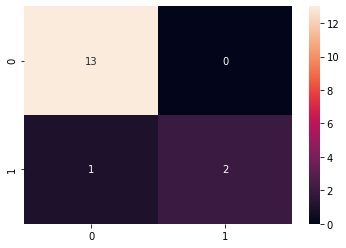

In [15]:
p7, t7 = run_model(7)

Positive Predictive Value tp/(tp+fp):  0.35
Recall Value tp/(tp+fn):  0.3181818181818182
[[94 13]
 [15  7]]


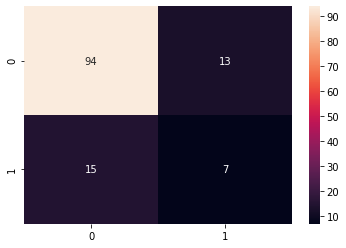

In [16]:
create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7)